In [3]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


Creating SimpleDeepAR model...
Initialized SimpleDeepAR model:
  Input size: 1
  Hidden size: 32
  Number of layers: 2
  Output size: 2

Generating dummy training data...
Created 50 sequences, each with length 100

Starting model training...
Starting training for 50 epochs with learning rate 0.001
Epoch 1/50, Average Loss: 0.9319
Epoch 2/50, Average Loss: 0.8607
Epoch 3/50, Average Loss: 0.7766
Epoch 4/50, Average Loss: 0.6620
Epoch 5/50, Average Loss: 0.5129
Epoch 6/50, Average Loss: 0.3998
Epoch 7/50, Average Loss: 0.2726
Epoch 8/50, Average Loss: 0.2226
Epoch 9/50, Average Loss: 0.1837
Epoch 10/50, Average Loss: 0.1085
Epoch 11/50, Average Loss: 0.0190
Epoch 12/50, Average Loss: -0.1255
Epoch 13/50, Average Loss: -0.3483
Epoch 14/50, Average Loss: -0.5618
Epoch 15/50, Average Loss: -0.7725
Epoch 16/50, Average Loss: -0.9897
Epoch 17/50, Average Loss: -1.0670
Epoch 18/50, Average Loss: -1.2260
Epoch 19/50, Average Loss: -1.3454
Epoch 20/50, Average Loss: -1.4085
Epoch 21/50, Average 

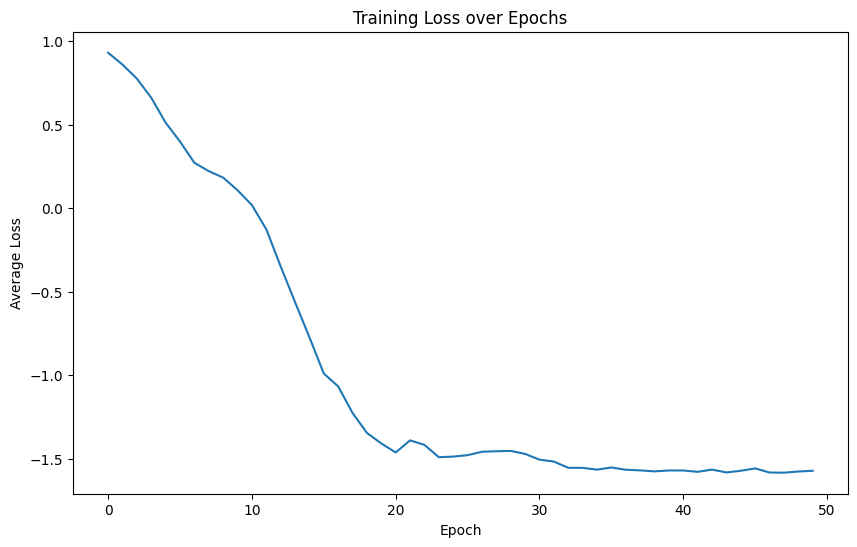


Making predictions with trained model...


KeyError: '99'

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from typing import Optional, Any

class SimpleDeepAR(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleDeepAR, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
        print(f"Initialized SimpleDeepAR model:")
        print(f"  Input size: {input_size}")
        print(f"  Hidden size: {hidden_size}")
        print(f"  Number of layers: {num_layers}")
        print(f"  Output size: {output_size}")
    
    def forward(self, x, hidden=None):
        output, (hidden, cell) = self.lstm(x, hidden)
        predictions = self.fc(output)
        return predictions, (hidden, cell)

def negative_gaussian_likelihood(y_true, mu, sigma):
    nll = 0.5 * torch.log(2 * np.pi * sigma**2) + 0.5 * ((y_true - mu)**2) / (sigma**2)
    return nll

def train_deepar(model, train_loader, num_epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    print(f"Starting training for {num_epochs} epochs with learning rate {learning_rate}")
    
    losses = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            optimizer.zero_grad()
            
            inputs = batch[:, :-1, :]
            targets = batch[:, 1:, 0]
            
            predictions, _ = model(inputs)
            mu = predictions[:, :, 0]
            sigma = torch.exp(predictions[:, :, 1])
            
            loss = negative_gaussian_likelihood(targets, mu, sigma).mean()
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    
    return losses

def plot_prediction_distribution(bootstrapping_predictions: pd.DataFrame,
                                 model_type: str,
                                 test_data: pd.Series,
                                 bw_method: Optional[Any] = None,
                                 **fig_kw) -> plt.Figure:
    index = bootstrapping_predictions.index.astype(str).to_list()[::-1]
    palette = plt.cm.viridis(np.linspace(0, 1, len(index)))
    
    # Remove test_data from fig_kw if it's there
    fig_kw.pop('test_data', None)
    
    fig, axs = plt.subplots(len(index), 1, sharex=True, **fig_kw)
    if not isinstance(axs, np.ndarray):
        axs = np.array([axs])

    # Create empty lists to store legend handles and labels
    legend_handles = []
    legend_labels = []

    for i, step in enumerate(index):
        plot = (
            bootstrapping_predictions.loc[step, :]
            .plot.kde(ax=axs[i], bw_method=bw_method, lw=0.5)
        )
        x = plot.get_children()[0]._x
        y = plot.get_children()[0]._y
        axs[i].fill_between(x, y, color=palette[i], alpha=0.6)
        
        prediction_mean = bootstrapping_predictions.loc[step, :].mean()
        idx = np.abs(x - prediction_mean).argmin()
        mean_line = axs[i].vlines(x[idx], ymin=0, ymax=y[idx], linestyle="dashed", color='black')
        
        # Plot the real test value in red
        real_value = test_data.loc[step]
        actual_line = axs[i].axvline(x=real_value, color='red', linestyle='--', linewidth=2)
        
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])
        axs[i].set_ylabel(step, rotation='horizontal')
        axs[i].set_xlabel('prediction')
        
        # Add legend handles and labels only once
        if i == 0:
            legend_handles.extend([mean_line, actual_line])
            legend_labels.extend(['Prediction Mean', 'Actual Value'])

    fig.subplots_adjust(hspace=-0.6)
    model_title = f"{model_type.upper()} Forecasting Distribution per Step"
    fig.suptitle(model_title)
    
    # Add a single legend for the entire figure
    fig.legend(legend_handles, legend_labels, loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=fig.transFigure)

    return fig

# Model configuration
input_size = 1
hidden_size = 32
num_layers = 2
output_size = 2

print("Creating SimpleDeepAR model...")
model = SimpleDeepAR(input_size, hidden_size, num_layers, output_size)

# Generate dummy training data
print("\nGenerating dummy training data...")
seq_length = 100
num_sequences = 50
batch_size = 10
scaler = MinMaxScaler(feature_range=(0, 1))

train_data = []
for _ in range(num_sequences):
    x = np.linspace(0, 4*np.pi, seq_length)
    y = np.sin(x) + np.random.normal(0, 0.1, seq_length)
    y_scaled = scaler.fit_transform(y.reshape(-1, 1))
    train_data.append(torch.FloatTensor(y_scaled))

train_data = torch.stack(train_data)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

print(f"Created {num_sequences} sequences, each with length {seq_length}")

# Training configuration
num_epochs = 50
learning_rate = 0.001

print("\nStarting model training...")
losses = train_deepar(model, train_loader, num_epochs, learning_rate)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.show()

# Make predictions
# Make predictions
print("\nMaking predictions with trained model...")
model.eval()
with torch.no_grad():
    test_sequence = train_data[0].unsqueeze(0)  # Add batch dimension
    true_data = scaler.inverse_transform(test_sequence.squeeze().numpy().reshape(-1, 1)).flatten()
    
    predictions, _ = model(test_sequence)
    predictions = predictions.squeeze().numpy()
    mu = scaler.inverse_transform(predictions[:, 0].reshape(-1, 1)).flatten()
    sigma = np.exp(predictions[:, 1])
    
    # Generate bootstrap samples
    num_bootstraps = 1000
    bootstrap_predictions = np.random.normal(mu.reshape(-1, 1), sigma.reshape(-1, 1), size=(len(mu), num_bootstraps))
    
    # Create DataFrame for bootstrap predictions
    bootstrap_df = pd.DataFrame(bootstrap_predictions, index=range(len(mu)), columns=[f'sample_{i}' for i in range(num_bootstraps)])
    
    # Create Series for true data
    true_series = pd.Series(true_data, index=range(len(mu)))
    
    # Plot distribution for all time steps
    fig = plot_prediction_distribution(bootstrap_df, 'DeepAR', true_series, figsize=(12, 20))
    plt.tight_layout()
    plt.show()


print("\nSimulation complete!")